In [22]:
# Data handling
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning utilities
from sklearn.model_selection import train_test_split   #Splits data into training and testing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler #LabelEncoder → convert text to numbers, MinMaxScaler → scale values between 0 and 1

# Models
from sklearn.ensemble import RandomForestClassifier #The prediction model for Fly / Delayed / No-Fly

# Evaluation
from sklearn.metrics import classification_report #Shows how good the predictions are

df = pd.read_csv("/content/aircraft_training_logs_with_pilots.csv")

### **USAGE OF AIRCRAFT**

In [2]:
usage_by_aircraft = (
    df.groupby("aircraft_id")["flight_hours"]
      .sum()
      .reset_index(name="total_flight_hours")
)

print(usage_by_aircraft)


  aircraft_id  total_flight_hours
0          A1              117.32
1          A2               98.72
2          A3              120.30
3          A4              107.41
4          A5               90.01


# **Average total flight hours across all aircraft**

In [3]:
fleet_avg = usage_by_aircraft["total_flight_hours"].mean()
print(fleet_avg)


106.752


# **Compares each aircraft’s usage to the average**

In [4]:
usage_by_aircraft["percent_vs_fleet_avg"] = (
    (usage_by_aircraft["total_flight_hours"] - fleet_avg)
    / fleet_avg * 100
).round(1)

print(usage_by_aircraft)


  aircraft_id  total_flight_hours  percent_vs_fleet_avg
0          A1              117.32                   9.9
1          A2               98.72                  -7.5
2          A3              120.30                  12.7
3          A4              107.41                   0.6
4          A5               90.01                 -15.7


## **Group by time_of_day**

In [5]:
usage_by_time = (
    df.groupby("time_of_day")["flight_hours"]
      .sum()
      .reset_index(name="total_flight_hours")
)

print(usage_by_time)


  time_of_day  total_flight_hours
0   Afternoon              168.43
1     Evening               92.98
2     Morning              272.35


## **Count Fly / Delayed / No-Fly by weather**

In [6]:
weather_counts = (
    df.groupby(["weather_condition", "flight_status"])
      .size()
      .reset_index(name="count")
)

print(weather_counts)


  weather_condition flight_status  count
0             Clear           Fly    250
1    Low Visibility        No-Fly     26
2              Rain       Delayed     35
3              Rain        No-Fly     28
4             Windy       Delayed     51
5             Windy           Fly     25
6             Windy        No-Fly      5


## **The percentages show, for each weather condition, how training flights are distributed between flying as scheduled, being delayed, or being cancelled.**

In [7]:
weather_status_pct = (
    weather_counts
    .assign(
        percent=lambda x: (
            x["count"]
            / x.groupby("weather_condition")["count"].transform("sum")
            * 100
        ).round(1)
    )
)

print(weather_status_pct)


  weather_condition flight_status  count  percent
0             Clear           Fly    250    100.0
1    Low Visibility        No-Fly     26    100.0
2              Rain       Delayed     35     55.6
3              Rain        No-Fly     28     44.4
4             Windy       Delayed     51     63.0
5             Windy           Fly     25     30.9
6             Windy        No-Fly      5      6.2


## **Filter only maintenance events**

In [8]:
maintenance_events = df[df["maintenance_flag"] == 1]
print(maintenance_events.shape)
print(maintenance_events.head())


(10, 15)
    aircraft_id flight_date training_type instructor_id time_of_day  \
35           A1  2025-10-11          Dual            I4     Evening   
64           A1  2025-12-12          Dual            I4     Morning   
122          A2  2025-10-10          Solo            I5     Morning   
151          A2  2025-12-12          Dual            I1     Morning   
191          A3  2025-10-06          Dual            I6     Morning   

    weather_condition  flight_hours  wind_speed visibility flight_status  \
35              Clear          1.24         7.3       Good           Fly   
64              Clear          1.32         6.5       Good           Fly   
122             Windy          0.75        26.5   Moderate       Delayed   
151             Clear          1.21         7.2       Good           Fly   
191             Clear          1.40        11.8       Good           Fly   

     hours_since_maintenance  maintenance_flag  downtime_days pilot_id  \
35                       0.0     

## **Count maintenance events per aircraft**

In [9]:
maintenance_by_aircraft = (
    maintenance_events.groupby("aircraft_id")
    .size()
    .reset_index(name="maintenance_count")
)

print(maintenance_by_aircraft)


  aircraft_id  maintenance_count
0          A1                  2
1          A2                  2
2          A3                  3
3          A4                  2
4          A5                  1


## **Selected weather and scheduling-related features to predict flight outcomes.**

In [10]:
model_df = df[
    ["weather_condition", "wind_speed", "visibility", "time_of_day", "flight_status"]
].copy()

print(model_df.head())


  weather_condition  wind_speed visibility time_of_day flight_status
0              Rain        15.6   Moderate   Afternoon       Delayed
1             Clear         9.6       Good     Morning           Fly
2             Clear         9.4       Good     Evening           Fly
3             Clear        14.6       Good     Morning           Fly
4             Clear        12.7       Good     Morning           Fly


## **Convert words into numbers (Encoding)**

In [11]:
le_weather = LabelEncoder()
le_visibility = LabelEncoder()
le_time = LabelEncoder()                            #create four separate encoders, one for each column.
le_target = LabelEncoder()

model_df["weather_condition_enc"] = le_weather.fit_transform(model_df["weather_condition"]) #Convert weather text into numbers, Clear → 0, Rain → 1, Windy → 2, Low Visibility → 3
model_df["visibility_enc"] = le_visibility.fit_transform(model_df["visibility"]) #Visibility is now numeric, Good → 0, Moderate → 1, Poor → 2
model_df["time_of_day_enc"] = le_time.fit_transform(model_df["time_of_day"]) #Time of day is now numeric, Morning → 0, Afternoon → 1, Evening → 2
model_df["flight_status_enc"] = le_target.fit_transform(model_df["flight_status"]) #This is the prediction target, Fly → 0, Delayed → 1, No-Fly → 2


weather_dict = {k: int(v) for k, v in zip(
    le_weather.classes_, le_weather.transform(le_weather.classes_)
)}

visibility_dict = {k: int(v) for k, v in zip(
    le_visibility.classes_, le_visibility.transform(le_visibility.classes_)
)}

time_of_day_dict = {k: int(v) for k, v in zip(
    le_time.classes_, le_time.transform(le_time.classes_)                              #Zipped for dictionary and prints the the variable with the number that encodedx
)}

flight_status_dict = {k: int(v) for k, v in zip(
    le_target.classes_, le_target.transform(le_target.classes_)
)}

print("Weather mapping:", weather_dict)
print("Visibility mapping:", visibility_dict)
print("Time of day mapping:", time_of_day_dict)
print("Flight status mapping:", flight_status_dict)

print(model_df[[
    "weather_condition", "weather_condition_enc",
    "visibility", "visibility_enc",                                 #Prints original text, encoded number
    "time_of_day", "time_of_day_enc",
    "flight_status", "flight_status_enc"
]].head())


Weather mapping: {'Clear': 0, 'Low Visibility': 1, 'Rain': 2, 'Windy': 3}
Visibility mapping: {'Good': 0, 'Moderate': 1, 'Poor': 2}
Time of day mapping: {'Afternoon': 0, 'Evening': 1, 'Morning': 2}
Flight status mapping: {'Delayed': 0, 'Fly': 1, 'No-Fly': 2}
  weather_condition  weather_condition_enc visibility  visibility_enc  \
0              Rain                      2   Moderate               1   
1             Clear                      0       Good               0   
2             Clear                      0       Good               0   
3             Clear                      0       Good               0   
4             Clear                      0       Good               0   

  time_of_day  time_of_day_enc flight_status  flight_status_enc  
0   Afternoon                0       Delayed                  0  
1     Morning                2           Fly                  1  
2     Evening                1           Fly                  1  
3     Morning                2        

## **Define inputs (X) and target (y)**

In [12]:
# Input features (what the model uses)
X = model_df[
    ["weather_condition_enc", "wind_speed", "visibility_enc", "time_of_day_enc"]
]

# Target variable (what we predict)
y = model_df["flight_status_enc"]

print("X shape:", X.shape)
print("y shape:", y.shape)
print(X.head())
print(y.head())


X shape: (420, 4)
y shape: (420,)
   weather_condition_enc  wind_speed  visibility_enc  time_of_day_enc
0                      2        15.6               1                0
1                      0         9.6               0                2
2                      0         9.4               0                1
3                      0        14.6               0                2
4                      0        12.7               0                2
0    0
1    1
2    1
3    1
4    1
Name: flight_status_enc, dtype: int64


## **Split data into Train & Test**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X,          # input features
    y,          # target
    test_size=0.25,   # 25% for testing
    random_state=42   # reproducible results
)

# Check sizes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (315, 4)
X_test shape: (105, 4)
y_train shape: (315,)
y_test shape: (105,)


## **Train Random Forest Classifier**

In [15]:
# Create the model
model = RandomForestClassifier(
    n_estimators=200,   # number of trees
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

print("Model training complete ✅")


Model training complete ✅


In [17]:
y_pred = model.predict(X_test)
print(y_pred[:10])   # show first 10 predictions (encoded)

print(classification_report(y_test, y_pred, target_names=le_target.classes_))

[1 1 1 1 0 1 2 1 0 1]
              precision    recall  f1-score   support

     Delayed       0.92      1.00      0.96        22
         Fly       1.00      1.00      1.00        63
      No-Fly       1.00      0.90      0.95        20

    accuracy                           0.98       105
   macro avg       0.97      0.97      0.97       105
weighted avg       0.98      0.98      0.98       105



In [27]:
corr_df = model_df[
    [
        "weather_condition_enc",
        "wind_speed",
        "visibility_enc",
        "time_of_day_enc",
        "flight_status_enc"
    ]
]

corr_matrix = corr_df.corr()
print(corr_matrix)


                       weather_condition_enc  wind_speed  visibility_enc  \
weather_condition_enc               1.000000    0.617487        0.426070   
wind_speed                          0.617487    1.000000        0.187158   
visibility_enc                      0.426070    0.187158        1.000000   
time_of_day_enc                     0.060699    0.024233       -0.037351   
flight_status_enc                  -0.333425   -0.259369        0.398075   

                       time_of_day_enc  flight_status_enc  
weather_condition_enc         0.060699          -0.333425  
wind_speed                    0.024233          -0.259369  
visibility_enc               -0.037351           0.398075  
time_of_day_enc               1.000000          -0.007926  
flight_status_enc            -0.007926           1.000000  


## **Correlation Matrix (Flight Operations)**

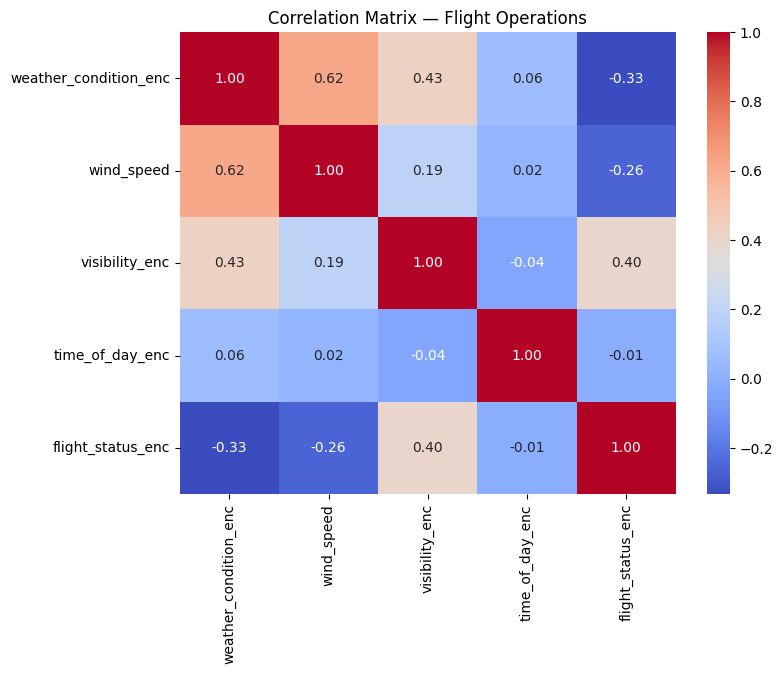

In [29]:
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Matrix — Flight Operations")
plt.show()


In [35]:
risk_df = (
    df.groupby("aircraft_id")
    .agg(
        total_flight_hours=("flight_hours", "sum"),
        maintenance_events=("maintenance_flag", "sum"),
        avg_downtime_days=("downtime_days", "mean")) #If Maintenance #1 → 4 days down, Maintenance #2 → 1 day down ((4 + 1) / 2 = 2.5 days)
    .reset_index()
)

print(risk_df)


  aircraft_id  total_flight_hours  maintenance_events  avg_downtime_days
0          A1              117.32                   2           0.090909
1          A2               98.72                   2           0.090909
2          A3              120.30                   3           0.086957
3          A4              107.41                   2           0.101124
4          A5               90.01                   1           0.040541


In [36]:
scaler = MinMaxScaler()

risk_features = ["total_flight_hours", "maintenance_events", "avg_downtime_days"]
risk_df[risk_features] = scaler.fit_transform(risk_df[risk_features])

print(risk_df)

#Here avg_downtime_days are b/w 0-1 Largest downtime → 1, Smallest downtime → 0


  aircraft_id  total_flight_hours  maintenance_events  avg_downtime_days
0          A1            0.901618                 0.5           0.831397
1          A2            0.287554                 0.5           0.831397
2          A3            1.000000                 1.0           0.766155
3          A4            0.574447                 0.5           1.000000
4          A5            0.000000                 0.0           0.000000


In [32]:
risk_df["maintenance_risk_score"] = (
    0.5 * risk_df["total_flight_hours"] +
    0.3 * risk_df["maintenance_events"] +
    0.2 * risk_df["avg_downtime_days"]
).round(2)

risk_df.sort_values("maintenance_risk_score", ascending=False)


,aircraft_id,total_flight_hours,maintenance_events,avg_downtime_days,maintenance_risk_score
2,A3,1.000000,1.0,0.766155,0.95
0,A1,0.901618,0.5,0.831397,0.77
3,A4,0.574447,0.5,1.000000,0.64
1,A2,0.287554,0.5,0.831397,0.46
4,A5,0.000000,0.0,0.000000,0.00


# **Maintenance Risk by Aircraft (Bar Chart)**

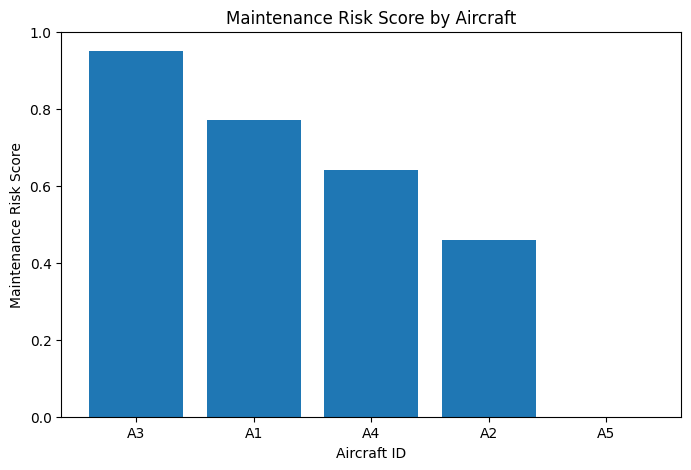

In [42]:
# If the column is missing, create it again
if "maintenance_risk_score" not in risk_df.columns:
    risk_df["maintenance_risk_score"] = (
        0.5 * risk_df["total_flight_hours"] +
        0.3 * risk_df["maintenance_events"] +
        0.2 * risk_df["avg_downtime_days"]
    ).round(2)

# Sort
risk_df_sorted = risk_df.sort_values("maintenance_risk_score", ascending=False)

# Plot
plt.figure(figsize=(8,5))
plt.bar(risk_df_sorted["aircraft_id"], risk_df_sorted["maintenance_risk_score"])
plt.title("Maintenance Risk Score by Aircraft")
plt.xlabel("Aircraft ID")
plt.ylabel("Maintenance Risk Score")
plt.ylim(0,1)
plt.show()


## **Pilot Scheduling Analytics**

In [43]:
# Merge risk score back to main dataframe
schedule_df = df.merge(
    risk_df[["aircraft_id", "maintenance_risk_score"]],
    on="aircraft_id",
    how="left"
)

print(schedule_df[
    ["pilot_id", "pilot_duty_status", "aircraft_id",
     "maintenance_risk_score", "weather_condition", "flight_status"]
].head())


  pilot_id pilot_duty_status aircraft_id  maintenance_risk_score  \
0       I4         Available          A1                    0.77   
1       I3         Available          A1                    0.77   
2       I6         Available          A1                    0.77   
3       I1         Available          A1                    0.77   
4       I4         Available          A1                    0.77   

  weather_condition flight_status  
0              Rain       Delayed  
1             Clear           Fly  
2             Clear           Fly  
3             Clear           Fly  
4             Clear           Fly  


In [44]:
def scheduling_decision(row):
    if row["pilot_duty_status"] != "Available":
        return "Do Not Assign"
    if row["flight_status"] != "Fly":
        return "Do Not Assign"
    if row["maintenance_risk_score"] >= 0.7:
        return "Avoid (High Aircraft Risk)"
    elif row["maintenance_risk_score"] >= 0.4:
        return "Assign with Caution"
    else:
        return "Assign"

schedule_df["scheduling_recommendation"] = schedule_df.apply(
    scheduling_decision, axis=1
)

schedule_df[
    ["pilot_id", "aircraft_id", "maintenance_risk_score",
     "weather_condition", "flight_status",
     "scheduling_recommendation"]
].head()


,pilot_id,aircraft_id,maintenance_risk_score,weather_condition,flight_status,scheduling_recommendation
0,I4,A1,0.77,Rain,Delayed,Do Not Assign
1,I3,A1,0.77,Clear,Fly,Avoid (High Aircraft Risk)
2,I6,A1,0.77,Clear,Fly,Avoid (High Aircraft Risk)
3,I1,A1,0.77,Clear,Fly,Avoid (High Aircraft Risk)
4,I4,A1,0.77,Clear,Fly,Avoid (High Aircraft Risk)


In [45]:
# Count how many rows in each scheduling recommendation
decision_counts = schedule_df["scheduling_recommendation"].value_counts()
print(decision_counts)

# Percentage view (more impressive)
decision_pct = (decision_counts / len(schedule_df) * 100).round(1)
print("\nPercent distribution:")
print(decision_pct)


scheduling_recommendation
Do Not Assign                 145
Avoid (High Aircraft Risk)    120
Assign with Caution           113
Assign                         42
Name: count, dtype: int64

Percent distribution:
scheduling_recommendation
Do Not Assign                 34.5
Avoid (High Aircraft Risk)    28.6
Assign with Caution           26.9
Assign                        10.0
Name: count, dtype: float64


In [46]:
final_schedule = schedule_df[
    schedule_df["scheduling_recommendation"].isin(
        ["Assign", "Assign with Caution"]
    )
]

final_schedule = final_schedule[
    ["pilot_id", "aircraft_id",
     "maintenance_risk_score",
     "weather_condition",
     "flight_status",
     "scheduling_recommendation"]
]

final_schedule.head()


,pilot_id,aircraft_id,maintenance_risk_score,weather_condition,flight_status,scheduling_recommendation
88,I1,A2,0.46,Clear,Fly,Assign with Caution
90,I6,A2,0.46,Clear,Fly,Assign with Caution
92,I1,A2,0.46,Clear,Fly,Assign with Caution
93,I5,A2,0.46,Clear,Fly,Assign with Caution
95,I1,A2,0.46,Clear,Fly,Assign with Caution


In [47]:
assignable = schedule_df[
    schedule_df["scheduling_recommendation"].isin(["Assign", "Assign with Caution"])
].copy()

assignable.shape, assignable.head()


((155, 17),
    aircraft_id flight_date training_type instructor_id time_of_day  \
 88          A2  2025-08-01          Dual            I1     Evening   
 90          A2  2025-08-05          Solo            I6   Afternoon   
 92          A2  2025-08-09          Dual            I1   Afternoon   
 93          A2  2025-08-11          Solo            I5     Evening   
 95          A2  2025-08-15          Solo            I1   Afternoon   
 
    weather_condition  flight_hours  wind_speed visibility flight_status  \
 88             Clear          1.30        13.7       Good           Fly   
 90             Clear          1.54        13.6       Good           Fly   
 92             Clear          1.11        12.5       Good           Fly   
 93             Clear          1.03         5.2       Good           Fly   
 95             Clear          1.48        11.1       Good           Fly   
 
     hours_since_maintenance  maintenance_flag  downtime_days pilot_id  \
 88                     0.00

In [48]:
daily_schedule = (
    assignable.sort_values("maintenance_risk_score")   # safer aircraft first
              .drop_duplicates(subset=["flight_date", "time_of_day"])
              [["flight_date", "time_of_day", "pilot_id", "aircraft_id",
                "maintenance_risk_score", "weather_condition",
                "flight_status", "scheduling_recommendation"]]
              .sort_values(["flight_date", "time_of_day"])
)

daily_schedule.head(20)


,flight_date,time_of_day,pilot_id,aircraft_id,maintenance_risk_score,weather_condition,flight_status,scheduling_recommendation
88,2025-08-01,Evening,I1,A2,0.46,Clear,Fly,Assign with Caution
346,2025-08-05,Afternoon,I5,A5,0.00,Clear,Fly,Assign
258,2025-08-08,Morning,I2,A4,0.64,Clear,Fly,Assign with Caution
92,2025-08-09,Afternoon,I1,A2,0.46,Clear,Fly,Assign with Caution
259,2025-08-10,Afternoon,I3,A4,0.64,Clear,Fly,Assign with Caution
93,2025-08-11,Evening,I5,A2,0.46,Clear,Fly,Assign with Caution
260,2025-08-12,Afternoon,I1,A4,0.64,Clear,Fly,Assign with Caution
95,2025-08-15,Afternoon,I1,A2,0.46,Clear,Fly,Assign with Caution
348,2025-08-16,Afternoon,I3,A5,0.00,Clear,Fly,Assign
96,2025-08-16,Morning,I6,A2,0.46,Clear,Fly,Assign with Caution
